# Plotting results of simply-supported Uflyand-Mindlin plates with Matplotlib

f:\GitHub\SigmaEpsilon\sigmaepsilon.solid.fourier\.solid.fourier\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


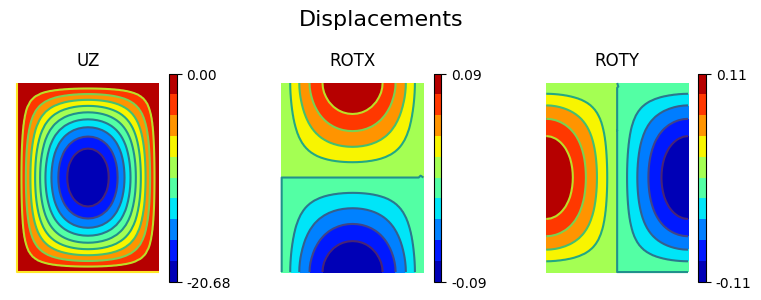

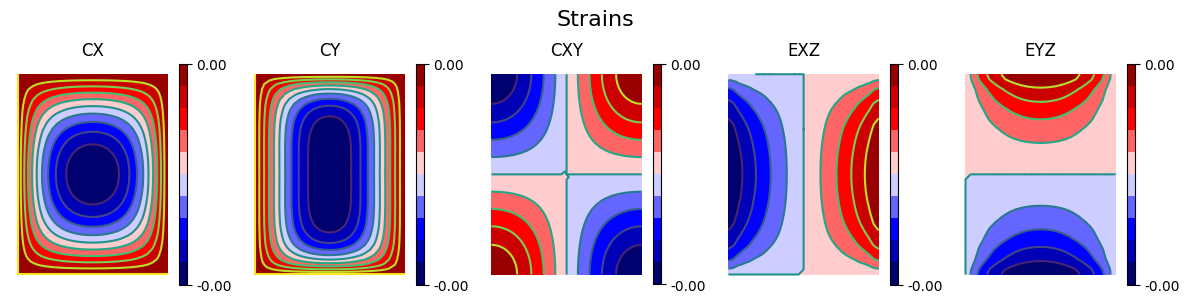

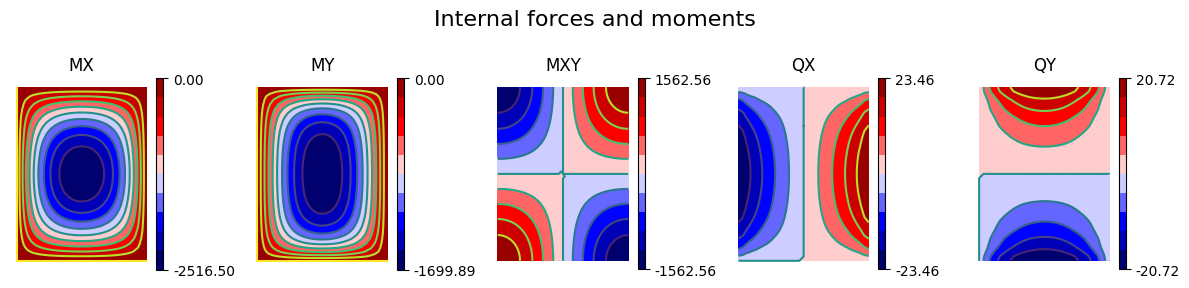

In [1]:
from numpy import ascontiguousarray as ascont

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3
from sigmaepsilon.mesh.plotting import triplot_mpl_data

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

size = Lx, Ly = (600.0, 800.0)
E = 2890.0
nu = 0.2
t = 25.0
yield_strength = 2.0

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=t),
    ]
)
ABDS = section.elastic_stiffness_matrix()
D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])

loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad(x=[[0, 0], [Lx, Ly]], v=[-0.1, 0, 0]),
        LC2=RectangleLoad(x=[[Lx / 3, Ly / 2], [Lx / 2, 2 * Ly / 3]], v=[-1, 0, 0]),
    ),
    LG2=LoadGroup(
        LC3=PointLoad(x=[Lx / 3, Ly / 2], v=[-100.0, 0, 0]),
        LC4=PointLoad(x=[2 * Lx / 3, Ly / 2], v=[100.0, 0, 0]),
    ),
)
loads.lock()

shape = nx, ny = (30, 40)
gridparams = {"size": size, "shape": shape, "eshape": "Q4"}
coords, topo = grid(**gridparams)
coords, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]

plate = RectangularPlate(size, (20, 20), D=D, S=S)
results = plate.solve(loads, coords)

plt.style.use("default")


UZ, ROTX, ROTY, CX, CY, CXY, EXZ, EYZ, MX, MY, MXY, QX, QY = list(range(13))
labels = {
    UZ: "UZ",
    ROTX: "ROTX",
    ROTY: "ROTY",
    CX: "CX",
    CY: "CY",
    CXY: "CXY",
    EXZ: "EXZ",
    EYZ: "EYZ",
    MX: "MX",
    MY: "MY",
    MXY: "MXY",
    QX: "QX",
    QY: "QY",
}
ilabels = {k: i for i, k in enumerate(labels)}


def plot2d(res2d):
    fig = plt.figure(figsize=(8, 3))  # in inches
    fig.patch.set_facecolor("white")
    cmap = "jet"
    gs = gridspec.GridSpec(1, 3)
    for i, key in enumerate([UZ, ROTX, ROTY]):
        ikey = ilabels[key]
        ax = fig.add_subplot(gs[i])
        triplot_mpl_data(
            triobj,
            ax=ax,
            fig=fig,
            title=labels[key],
            data=res2d[:, ikey],
            cmap=cmap,
            axis="off",
            nlevels=10,
            lw=0
        )
    fig.suptitle("Displacements", fontsize=16)
    fig.tight_layout()

    fig = plt.figure(figsize=(12, 3))  # in inches
    fig.patch.set_facecolor("white")
    cmap = "seismic"
    gs = gridspec.GridSpec(1, 5)
    for i, key in enumerate([CX, CY, CXY, EXZ, EYZ]):
        ikey = ilabels[key]
        ax = fig.add_subplot(gs[i])
        triplot_mpl_data(
            triobj,
            ax=ax,
            fig=fig,
            title=labels[key],
            data=res2d[:, ikey],
            cmap=cmap,
            axis="off",
            nlevels=10,
            lw=0
        )
    fig.suptitle("Strains", fontsize=16)
    fig.tight_layout()
    
    fig = plt.figure(figsize=(12, 3))  # in inches
    fig.patch.set_facecolor("white")
    cmap = "seismic"
    gs = gridspec.GridSpec(1, 5)
    for i, key in enumerate([MX, MY, MXY, QX, QY]):
        ikey = ilabels[key]
        ax = fig.add_subplot(gs[i])
        triplot_mpl_data(
            triobj,
            ax=ax,
            fig=fig,
            title=labels[key],
            data=res2d[:, ikey],
            cmap=cmap,
            axis="off",
            nlevels=10,
            lw=0
        )
    fig.suptitle("Internal forces and moments", fontsize=16)
    fig.tight_layout()
    
plot2d(results["LG1", "LC1"].values)